## Libraries

In [26]:
import os
import importlib

import numpy as np
import tensorflow as tf
import pandas as pd


if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    import sys
    project_path = 'drive/MyDrive/Colab Notebooks/weather_forecasting/'
    sys.path.append(project_path)
else:
    project_path = ''

import weather_forecast
importlib.reload(weather_forecast)

<module 'weather_forecast' from 'C:\\Users\\migue\\Documents\\Trabajos\\weather_prediction\\weather_forecast.py'>

## Data loading

In [2]:
# Load data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

# Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train = df[0:int(n*0.7)]
val = df[int(n*0.7):int(n*0.9)]
test = df[int(n*0.9):]

## Preprocessing pipeline

In [3]:
preprocess_pl = weather_forecast.WeatherPreprocessing()

train_df = preprocess_pl.fit_transform(data=train)

val_df = preprocess_pl.transform(data=val)

test_df = preprocess_pl.transform(data=test)

num_features = train_df.shape[1]

preprocess_pl.save_params(project_path + 'model/preprocess_params.csv')

## Window generator

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['T (degC)']

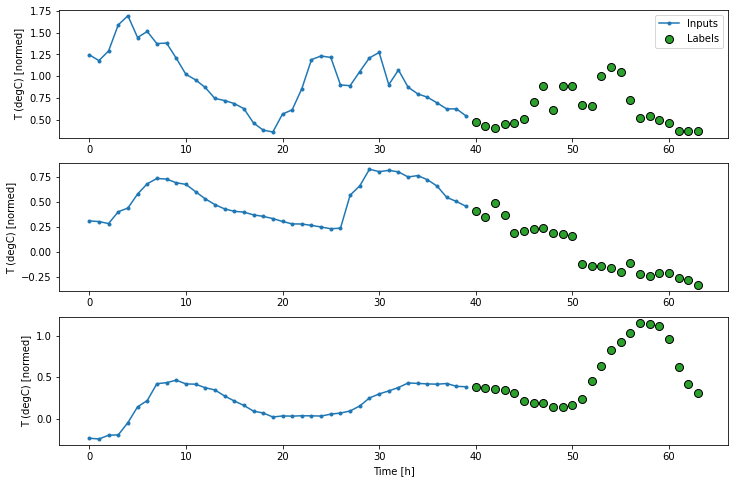

In [27]:
OUT_STEPS = 24
multi_window = weather_forecast.WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=40,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['T (degC)']
)

multi_window.plot()
multi_window

## Define model

In [15]:
model = weather_forecast.WeatherModel(input_shape=(multi_window.input_width, len(multi_window.column_indices)), out_steps=OUT_STEPS)

model.load_weights(filepath = project_path + 'model/weather_model.h5')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 19)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1536      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                312       
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 1)             0         
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________


In [28]:
multi_window.plot_interactive(model)

In [43]:
fig = go.Figure([go.Scatter(y=preds[0,:,0])])
fig.show()